In [85]:
import keras
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

# Open the AAPL stock file from the ticker_data dir
TICKER_DIR = "C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\ticker_data"
df = pd.read_csv(f"{TICKER_DIR}\\MSFT.csv", header=0)

print(df.shape)

# Our target is the close price of the stock
target = df["close"].tail(1000)
dataset = df[["high", "low", "open"]].tail(1000)

(1006, 13)


In [86]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i, _ in enumerate(sequences):
		end_ix = i + n_steps
		if end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

n_steps = 5

high = dataset["high"].values.reshape(len(dataset), 1)
low = dataset["low"].values.reshape(len(dataset), 1)
open = dataset["open"].values.reshape(len(dataset), 1)
close = target.values.reshape(len(dataset), 1)

# stack them horizontally
d = np.hstack((open, high, low, close))
# split sequences
X, y = split_sequences(d, n_steps)

n_features = X.shape[2]
print(d.shape)
print(X.shape)
print(y.shape)

(1000, 4)
(996, 5, 4)
(996, 4)


In [79]:
# clears previous sessions
keras.backend.clear_session()
# create a Sequential model, 2 LSTM 100 node layers & 1 fully connected layer
model = Sequential()
model.add(LSTM(100, activation="relu", return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation="relu"))
model.add(Dense(n_features))
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss="mae", metrics=["mae", "mse"])

# split dataset to training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

model.fit(X_train, y_train, epochs=500, verbose=1)

s/step - loss: 0.6840 - mae: 0.6840 - mse: 0.9348
Epoch 326/500
796/796 [==============================] - 0s 188us/step - loss: 0.7457 - mae: 0.7457 - mse: 1.0433
Epoch 327/500
796/796 [==============================] - 0s 192us/step - loss: 0.7208 - mae: 0.7208 - mse: 0.9903
Epoch 328/500
796/796 [==============================] - 0s 180us/step - loss: 0.7284 - mae: 0.7284 - mse: 1.0219
Epoch 329/500
796/796 [==============================] - 0s 183us/step - loss: 0.7873 - mae: 0.7873 - mse: 1.1297
Epoch 330/500
796/796 [==============================] - 0s 177us/step - loss: 0.8043 - mae: 0.8043 - mse: 1.2035
Epoch 331/500
796/796 [==============================] - 0s 204us/step - loss: 0.8418 - mae: 0.8418 - mse: 1.2830
Epoch 332/500
796/796 [==============================] - 0s 185us/step - loss: 0.7725 - mae: 0.7725 - mse: 1.1164
Epoch 333/500
796/796 [==============================] - 0s 175us/step - loss: 0.6890 - mae: 0.6890 - mse: 0.9423
Epoch 334/500
796/796 [===============

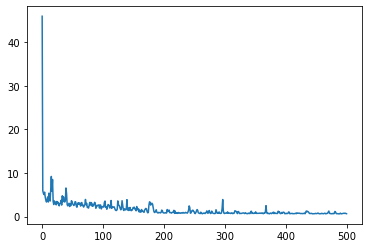

In [80]:
# plot the model's loss history
model.history.history.keys()
plt.plot(model.history.history["loss"])

In [81]:
# evaluate the model with the testing datasets
scores = model.evaluate(X_test, y_test, verbose=0)
print(*[f"History Item [{item}] reports value of {value}" for value, item in zip(scores, model.metrics_names)], sep="\n")

History Item [loss] reports value of 1.0296818923950195
History Item [mae] reports value of 1.0296818017959595
History Item [mse] reports value of 1.7632428407669067


In [82]:
# take the last 36 close values for testing
# 36 is the size of the testing set
actual = df["close"].tail(X_test.shape[0]).values
yhat = model.predict(X_test, verbose=0)
predictions = yhat[:, -1]

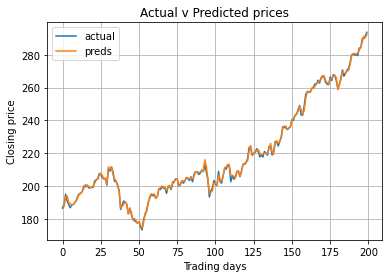

In [83]:
# plot the predicted values against the actual values
fig = plt.figure()
plt.title("Actual v Predicted prices")
plt.ylabel("Closing price")
plt.xlabel("Trading days")
plt.plot(actual, label="actual")
plt.plot(predictions, label="preds")
plt.grid()
plt.legend()
# plt.savefig("C:\\Users\\anton\\Documents\\antoniouaa\\msc_thesis\\data\\tickers\\MSFT.png")